In [4]:
import json
import pandas as pd
from pytorchyolo import detect
from object_detection import load_model, load_class
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

/home/omm/anaconda3/envs/hate/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataDir = './data/hateful_memes'
f = os.path.join(dataDir, 'train.jsonl')

rows = []
with open(f, 'r') as file:
    for line in file:
        data = json.loads(line)
        rows.append(data)

train_df = pd.DataFrame(rows)
train_df.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [6]:
print('Distribution')
train_df.label.value_counts().to_frame()

Distribution


,label
0,5481
1,3019


### Collect Detected Objects from Dataset

In [5]:
if not os.path.exists('./data/object.csv'):
        config = 'data/yolov3.cfg'
        weight = 'data/yolov3.weights'
        classes_path = 'data/coco.names'
        model = load_model(config, weight)
        classes = load_class(classes_path)
        objects = []
        for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0], desc='Processing images'):
                f = os.path.join(dataDir, row.img)
                img = cv2.imread(f)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                boxes = detect.detect_image(model, img)
                for i,box in enumerate(boxes):
                        x1, y1, x2, y2, confidence, class_id = box
                        width = x2 - x1
                        height = y2 - y1
                        area = width * height
                        objects.append({'id':row.id, 
                                        'object_id':i+1,
                                        'area':area,
                                        'confidence':confidence,
                                        'class_name':classes[int(class_id)],
                                        'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2
                                        })
        object_df = pd.DataFrame(objects)
        object_df.to_csv('./data/object.csv', index=False)
        # del object_df
        del objects
else:
        object_df = pd.read_csv('./data/object.csv')

In [75]:
object_df.head()

,id,object_id,area,confidence,class_name,x1,y1,x2,y2
0,42953,1,33100.402,0.996637,person,14.414126,33.951760,209.89580,203.27914
1,42953,2,35210.210,0.878665,person,75.512634,208.366490,266.28027,392.93768
2,23058,1,171329.440,0.992758,person,377.652650,54.574993,753.69800,510.18340
3,23058,2,120560.650,0.978763,person,109.964060,161.976210,428.99365,539.87420
4,23058,3,5311.506,0.905741,tie,454.693240,266.004500,499.67014,384.09857


In [9]:
print('Maximum objects found per image:',object_df.groupby(by=['id']).object_id.count().max())

Maximum objects found per image: 39


### Count of Detected Object in Dataset
Plot is done exclusing the `person` class, to maintain the scale. 

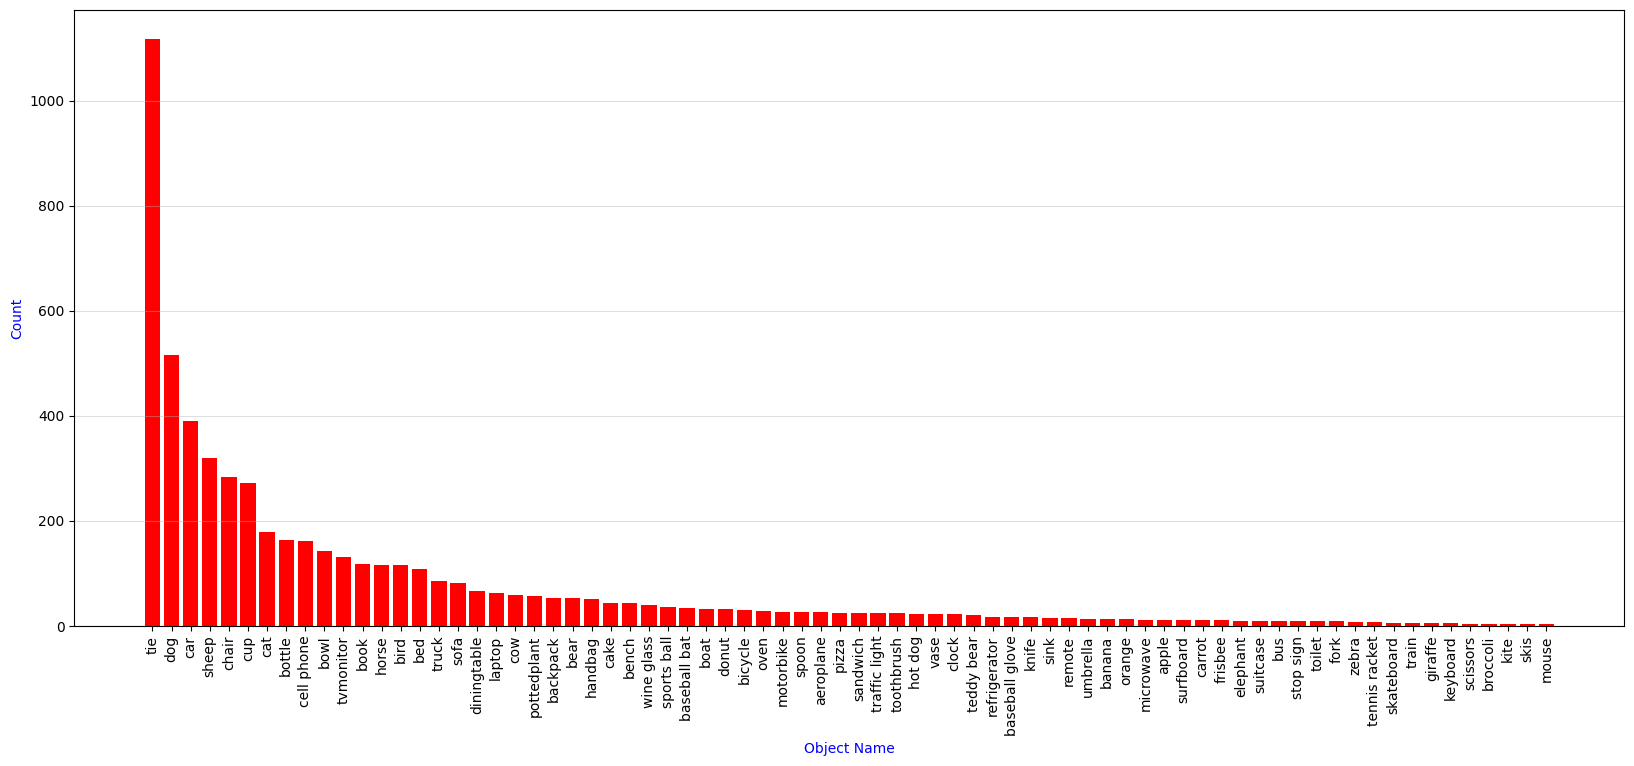

In [55]:
x = object_df.class_name.value_counts().index.to_list()
y = object_df.class_name.value_counts().to_list()

plt.figure(figsize=(20,8))
plt.bar(x[1:],y[1:], color='r')
# plt.bar(x,y)
plt.xticks(rotation='vertical')
plt.grid(axis='y', alpha=0.4)
plt.ylabel('Count', color='b')
plt.xlabel('Object Name', color='b')
plt.show()

There are many other object categories, but only category, i.e., avialble in `COCO` classes are detected.

### Average Confidence of Detected Classes 

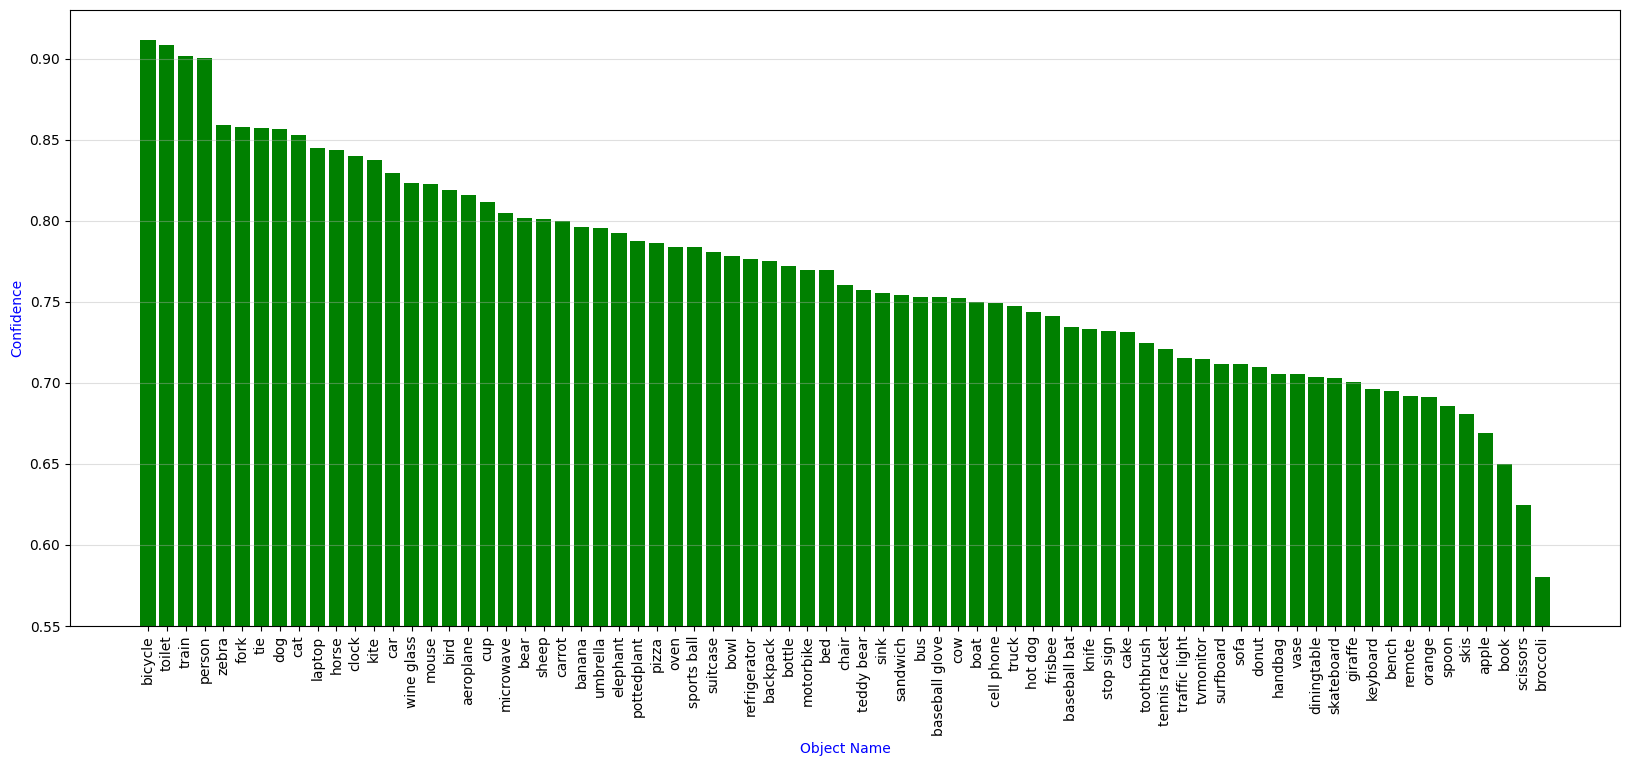

In [71]:
y = object_df.groupby(by=['class_name']).confidence.mean().sort_values(ascending=False).to_list()
x = object_df.groupby(by=['class_name']).confidence.mean().sort_values(ascending=False).index.to_list()

plt.figure(figsize=(20,8))
# plt.bar(x[1:],y[1:], color='r')
plt.bar(x,y, color='g')
plt.xticks(rotation='vertical')
plt.grid(axis='y', alpha=0.4)
plt.ylim(bottom=0.55, top=0.93)
plt.ylabel('Confidence', color='b')
plt.xlabel('Object Name', color='b')
plt.show()

### Average Area of Detected Classes 

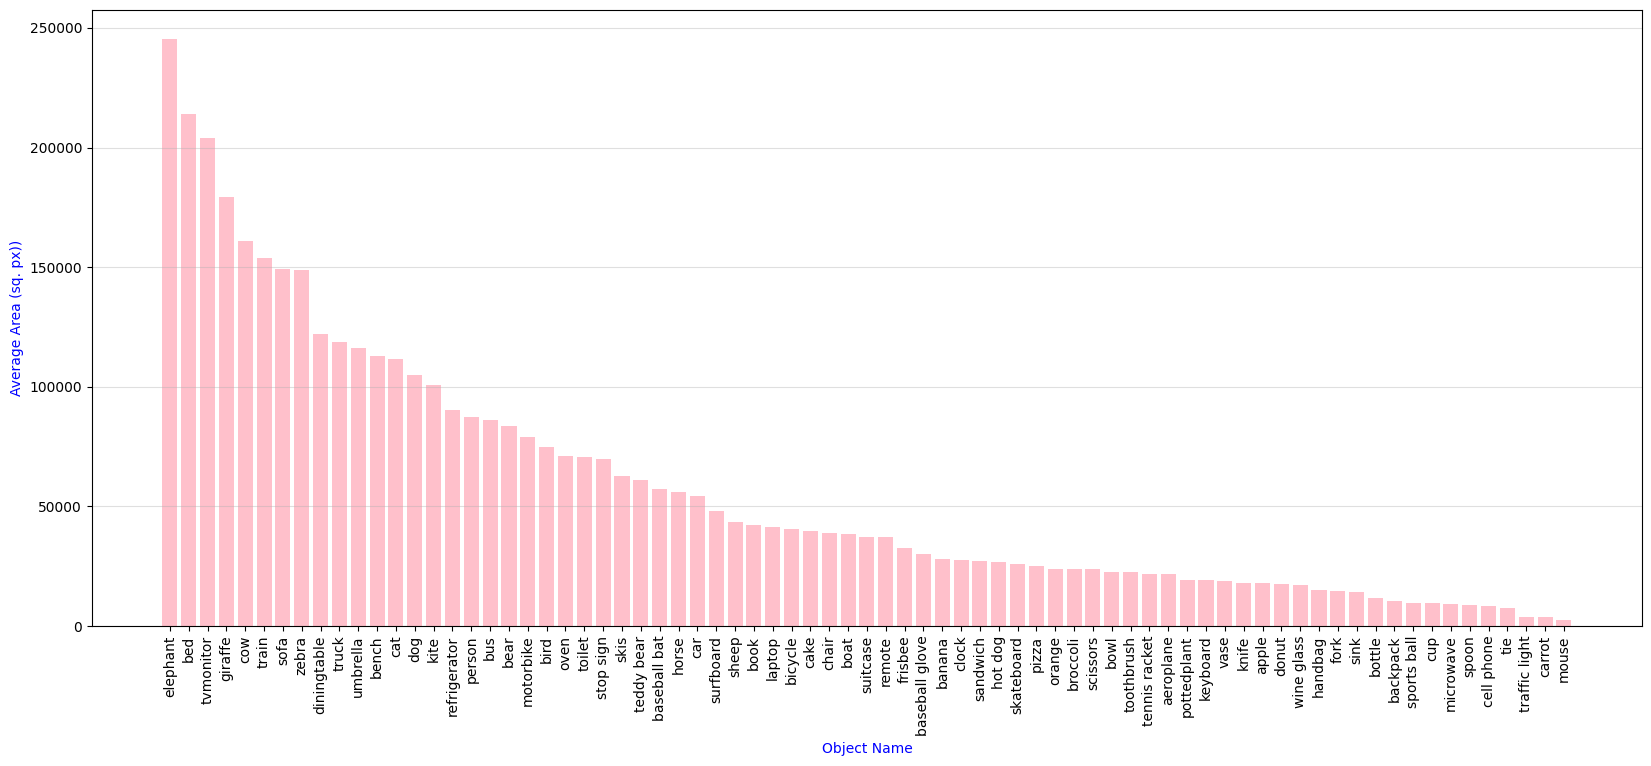

In [77]:
y = object_df.groupby(by=['class_name']).area.mean().sort_values(ascending=False).to_list()
x = object_df.groupby(by=['class_name']).area.mean().sort_values(ascending=False).index.to_list()

plt.figure(figsize=(20,8))
plt.bar(x,y, color='pink')
plt.xticks(rotation='vertical')
plt.grid(axis='y', alpha=0.4)
# plt.ylim(bottom=0.55, top=0.93)
plt.ylabel('Average Area (sq. px))', color='b')
plt.xlabel('Object Name', color='b')
plt.show()